## **Alternative Tracing Methods**
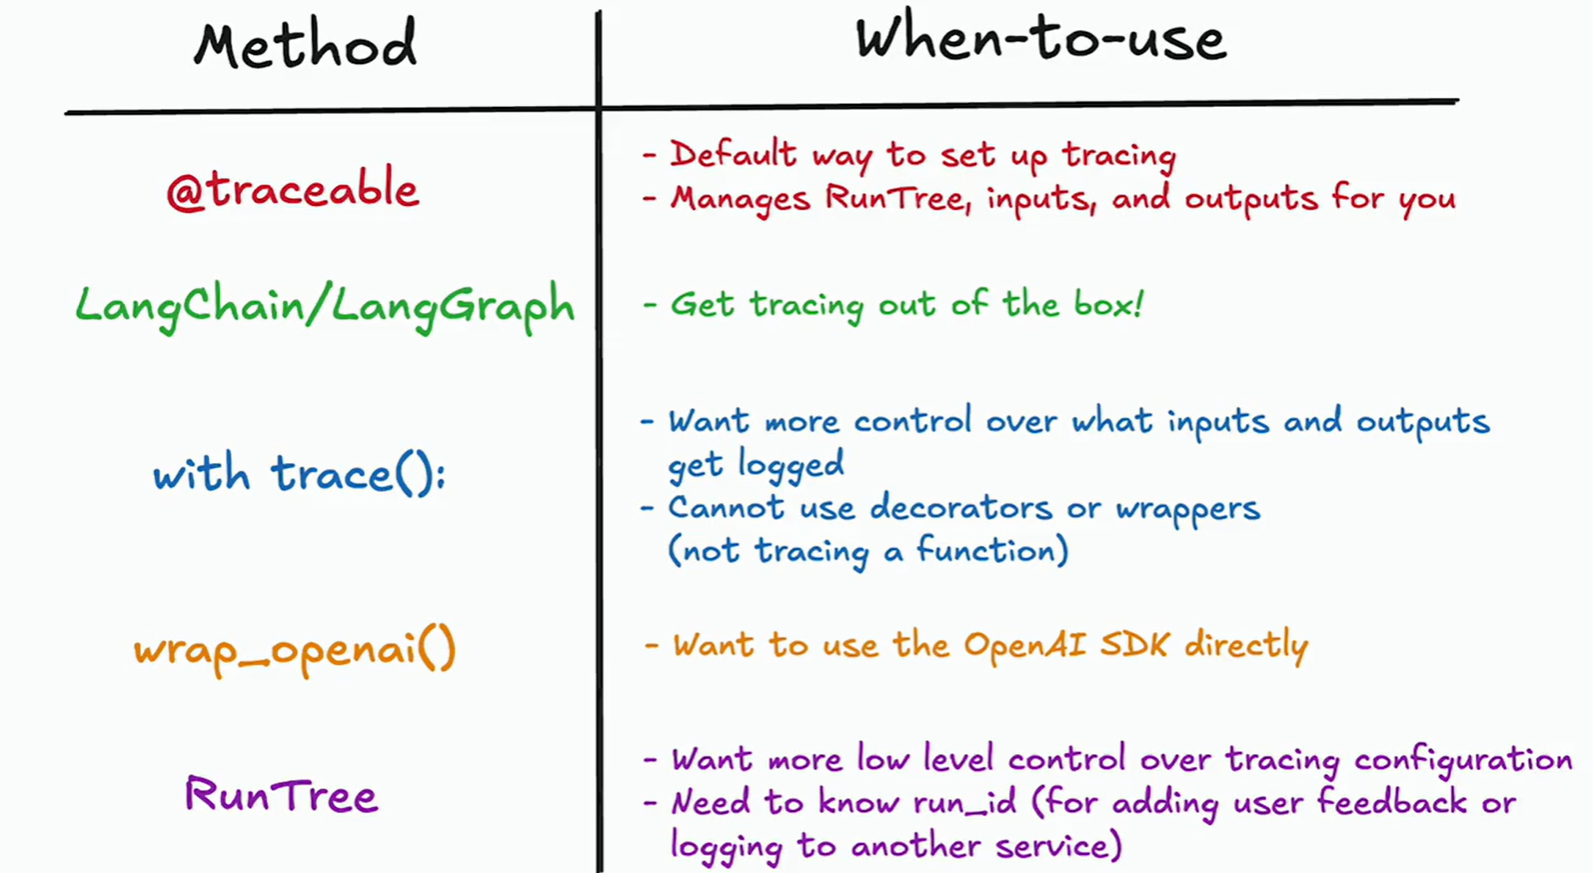
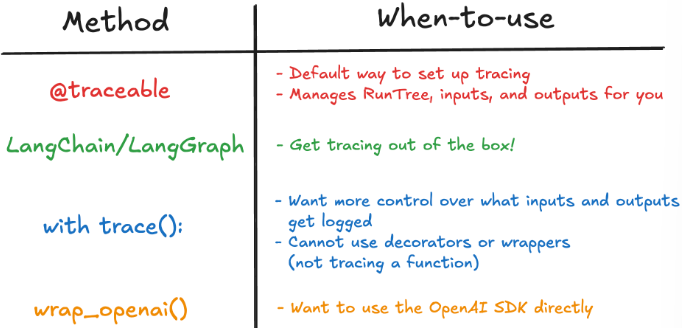

In [28]:
from dotenv import load_dotenv, find_dotenv

_ = load_dotenv(find_dotenv())

### **LangChain and LangGraph**

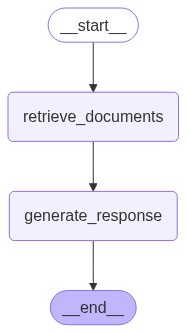

In [ ]:
import nest_asyncio
import operator
from langchain.schema import Document
from langchain_core.messages import HumanMessage, AnyMessage, get_buffer_string
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, END
from IPython.display import Image, display
from typing import List
from typing_extensions import TypedDict, Annotated
from utils import get_vector_db_retriever, RAG_PROMPT

nest_asyncio.apply()

retriever = get_vector_db_retriever()
chat = ChatOpenAI(model_name = "gpt-4o-mini", temperature = 0)

# Define Graph state
class GraphState(TypedDict):
    question: str
    messages: Annotated[List[AnyMessage], operator.add]
    documents: List[Document]

# Define Nodes
def retrieve_documents(state: GraphState):
    question = state["question"]
    messages = state.get("messages", [])
    documents = retriever.invoke(f"{get_buffer_string(messages)} {question}")
    return {"documents": documents}

def generate_response(state: GraphState):
    question = state["question"]
    messages = state["messages"]
    documents = state["documents"]
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    
    rag_prompt_formatted = RAG_PROMPT.format(
                                context = formatted_docs, 
                                conversation = messages, 
                                question = question
                            )
    generation = chat.invoke([HumanMessage(content = rag_prompt_formatted)])
    return {"documents": documents, "messages": [HumanMessage(question), generation]}

# Define Graph
graph_builder = StateGraph(GraphState)
graph_builder.add_node("retrieve_documents", retrieve_documents)
graph_builder.add_node("generate_response", generate_response)

graph_builder.set_entry_point("retrieve_documents")
graph_builder.add_edge("retrieve_documents", "generate_response")
graph_builder.add_edge("generate_response", END)

simple_rag_graph = graph_builder.compile()
display(Image(simple_rag_graph.get_graph().draw_mermaid_png()))

In [5]:
question = "How do I set up tracing if I'm using LangChain?"
simple_rag_graph.invoke({"question": question}, config = {"metadata": {"foo": "bar"}})

{'question': "How do I set up tracing if I'm using LangChain?",
 'messages': [HumanMessage(content="How do I set up tracing if I'm using LangChain?", additional_kwargs={}, response_metadata={}),
  AIMessage(content='To set up tracing with LangChain, first install the LangGraph library and the OpenAI integration for your programming language. Then, configure your environment by setting the necessary environment variables, including `LANGSMITH_TRACING` and your API keys. For more detailed instructions, refer to the Trace With LangChain guide.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 63, 'prompt_tokens': 701, 'total_tokens': 764, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_34a54ae93c', 'id': 'chatcmpl-BlXt0pX0a0

### **Tracing Context Manager**

In [ ]:
from langsmith import traceable, trace
from openai import OpenAI
from typing import List
import nest_asyncio
from utils import get_vector_db_retriever

MODEL_PROVIDER = "openai"
MODEL_NAME = "gpt-4o-mini"
APP_VERSION = 1.0
RAG_SYSTEM_PROMPT = """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the latest question in the conversation. 
If you don't know the answer, just say that you don't know. 
Use three sentences maximum and keep the answer concise.
"""

openai_client = OpenAI()
nest_asyncio.apply()
retriever = get_vector_db_retriever()

"""
retrieve_documents
- Returns documents fetched from a vectorstore based on the user's question
"""
@traceable
def retrieve_documents(question: str):
    documents = retriever.invoke(question)
    return documents

"""
generate_response
- Calls `call_openai` to generate a model response after formatting inputs
"""
# TODO: Remove traceable, and use with trace()
def generate_response(question: str, documents):
    # NOTE: Our documents came in as a list of objects, but we just want to log a string
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)

    # TODO: Use with trace()
    with trace(
        name = "Generate Response",
        run_type = "chain", 
        inputs = {"question": question, "formatted_docs": formatted_docs},
        metadata = {"foo": "bar"},
    ) as ls_trace:
        messages = [
            {
                "role": "system",
                "content": RAG_SYSTEM_PROMPT
            },
            {
                "role": "user",
                "content": f"Context: {formatted_docs} \n\n Question: {question}"
            }
        ]
    response = call_openai(messages)
    # TODO: End your trace and write outputs to LangSmith
    ls_trace.end(outputs = {"output": response})
    return response

"""
call_openai
- Returns the chat completion output from OpenAI
"""
@traceable
def call_openai(
    messages: List[dict], model: str = MODEL_NAME, temperature: float = 0.0
) -> str:
    response = openai_client.chat.completions.create(
        model = model,
        messages = messages,
        temperature = temperature,
    )
    return response

"""
langsmith_rag
- Calls `retrieve_documents` to fetch documents
- Calls `generate_response` to generate a response based on the fetched documents
- Returns the model response
"""
@traceable
def langsmith_rag(question: str):
    documents = retrieve_documents(question)
    response = generate_response(question, documents)
    return response.choices[0].message.content

In [ ]:
question = "How do I trace with tracing context?"
ai_answer = langsmith_rag(question)
print(ai_answer)

To trace with the tracing context in Python, you should use the `with tracing_context:` context manager. This allows you to log traces for specific blocks of code while providing control over inputs, outputs, and other attributes. This method is recommended for enabling or disabling tracing without needing to set environment variables.


### **wrap_openai**

In [20]:
# TODO: Import wrap_openai
from langsmith.wrappers import wrap_openai
import openai
import nest_asyncio
from utils import get_vector_db_retriever

MODEL_PROVIDER = "openai"
MODEL_NAME = "gpt-4o-mini"
APP_VERSION = 1.0
RAG_SYSTEM_PROMPT = """You are an assistant for question-answering tasks. 
Use the following pieces of retrieved context to answer the latest question in the conversation. 
If you don't know the answer, just say that you don't know. 
Use three sentences maximum and keep the answer concise.
"""

# TODO: Wrap the OpenAI Client
openai_client = wrap_openai(openai.Client())

nest_asyncio.apply()
retriever = get_vector_db_retriever()

@traceable(run_type = "chain")
def retrieve_documents(question: str):
    return retriever.invoke(question)

@traceable(run_type = "chain")
def generate_response(question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    messages = [
        {
            "role": "system",
            "content": RAG_SYSTEM_PROMPT
        },
        {
            "role": "user",
            "content": f"Context: {formatted_docs} \n\n Question: {question}"
        }
    ]
    # TODO: We don't need to use @traceable on a nested function call anymore,
    # wrap_openai takes care of this for us
    return openai_client.chat.completions.create(
        model = MODEL_NAME,
        messages = messages,
    )

@traceable(run_type = "chain")
def langsmith_rag_with_wrap_openai(question: str):
    documents = retrieve_documents(question)
    response = generate_response(question, documents)
    return response.choices[0].message.content

In [22]:
question = "How do I trace with wrap_openai?"
ai_answer = langsmith_rag_with_wrap_openai(question)
print(ai_answer)

To trace with `wrap_openai`, you need to import it and wrap your OpenAI client by modifying your code to use the wrapped client instead of the direct OpenAI client. Ensure that the `LANGSMITH_TRACING` environment variable is set to 'true' to log traces, and also set the `LANGSMITH_API_KEY` with your API key. When you call your function, it will generate a trace of the OpenAI call, which can be logged under a default project unless specified otherwise.


In [23]:
messages = [
    {
        "role": "user",
        "content": "What color is the sky?"
    }
]

openai_client.chat.completions.create(
    model = MODEL_NAME,
    messages = messages,
    langsmith_extra = {"metadata": {"foo": "bar"}},
)

ChatCompletion(id='chatcmpl-BlYPIU7yatJH7PG1hvH37NrVP30nM', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content="The color of the sky appears blue during the day due to a phenomenon called Rayleigh scattering, where shorter wavelengths of light (blue) are scattered in all directions by the gases and particles in the Earth's atmosphere. During sunrise and sunset, the sky can take on hues of orange, pink, and red because the light has to travel through more atmosphere, scattering the shorter wavelengths and allowing the longer wavelengths (reds and oranges) to become more prominent. The sky can also appear gray or white when overcast or during storms.", refusal=None, role='assistant', annotations=[], audio=None, function_call=None, tool_calls=None))], created=1750673376, model='gpt-4o-mini-2024-07-18', object='chat.completion', service_tier='default', system_fingerprint='fp_34a54ae93c', usage=CompletionUsage(completion_tokens=104, prompt_to

### **[Advanceed] RunTree**

In [29]:
import os
os.environ["LANGSMITH_TRACING"] = "false"

from langsmith import utils
utils.tracing_is_enabled() # This should return false

True

In [30]:
from langsmith import RunTree
from openai import OpenAI
from typing import List
import nest_asyncio
from utils import get_vector_db_retriever

openai_client = OpenAI()
nest_asyncio.apply()
retriever = get_vector_db_retriever()

def retrieve_documents(parent_run: RunTree, question: str):
    # Create a child run
    child_run = parent_run.create_child(
        name = "Retrieve Documents",
        run_type = "retriever",
        inputs = {"question": question},
    )
    documents = retriever.invoke(question)
    # Post the output of our child run
    child_run.end(outputs = {"documents": documents})
    child_run.post()
    return documents

def generate_response(parent_run: RunTree, question: str, documents):
    formatted_docs = "\n\n".join(doc.page_content for doc in documents)
    rag_system_prompt = """You are an assistant for question-answering tasks. 
    Use the following pieces of retrieved context to answer the latest question in the conversation. 
    If you don't know the answer, just say that you don't know. 
    Use three sentences maximum and keep the answer concise.
    """
    # Create a child run
    child_run = parent_run.create_child(
        name = "Generate Response",
        run_type = "chain",
        inputs = {"question": question, "documents": documents},
    )
    messages = [
        {
            "role": "system",
            "content": rag_system_prompt
        },
        {
            "role": "user",
            "content": f"Context: {formatted_docs} \n\n Question: {question}"
        }
    ]
    openai_response = call_openai(child_run, messages)
    # Post the output of our child run
    child_run.end(outputs={"openai_response": openai_response})
    child_run.post()
    return openai_response

def call_openai(
    parent_run: RunTree, messages: List[dict], model: str = "gpt-4o-mini", temperature: float = 0.0
) -> str:
    # Create a child run
    child_run = parent_run.create_child(
        name = "OpenAI Call",
        run_type = "llm",
        inputs = {"messages": messages},
    )
    openai_response = openai_client.chat.completions.create(
        model = model,
        messages = messages,
        temperature = temperature,
    )
    # Post the output of our child run
    child_run.end(outputs={"openai_response": openai_response})
    child_run.post()
    return openai_response

def langsmith_rag(question: str):
    # Create a root RunTree
    root_run_tree = RunTree(
        name = "Chat Pipeline",
        run_type = "chain",
        inputs = {"question": question}
    )

    # Pass our RunTree into the nested function calls
    documents = retrieve_documents(root_run_tree, question)
    response = generate_response(root_run_tree, question, documents)
    output = response.choices[0].message.content

    # Post our final output
    root_run_tree.end(outputs={"generation": output})
    root_run_tree.post()
    return output

In [31]:
question = "How can I trace with RunTree?"
ai_answer = langsmith_rag(question)
print(ai_answer)

You can trace with RunTree by using the `RunTree.fromRunnableConfig` method to convert a `RunnableConfig` into a `RunTree` object. Additionally, you can call the `get_current_run_tree` function to access the current run. Ensure to manage run rules and filtering conditions to optimize data retention and sampling rates for your traces.
